# Image Classification



**Goal:** Given many images and their labels, learn a neural network to predict the label of a new image (c.f human learning).

**Repetitions:**
- Define Model & Optimization Strategy
- Fit Model
- Monitor Fitting
- Evaluate Training 

**New items:**

- Data Splitting: Train & Test
- How to handle images: data structure

- 

# Get Libraries

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
print('tf-version: ', tf.__version__)

# my plot function for confusion matrix
def plot_cm(mat):
  classes = np.arange(cm.shape[0])
  plt.imshow(mat, cmap=plt.cm.Blues)
  for (j,i),label in np.ndenumerate(mat):
    plt.text(i,j,np.round(label,2),ha='center',va='center')

  plt.colorbar()
  plt.title('Confusion Matrix')
  plt.xlabel('True label')
  plt.ylabel('Pred label')
  plt.xticks(classes)
  plt.yticks(classes)
  plt.show()

tf-version:  2.4.1


## Get Data

Many famous datasets can be found here:  https://www.tensorflow.org/datasets/catalog/overview

They can be accessed easily using keras functionality.

In the following we will focus on squared images of handwritten digits. They have also been annotated (labeled).

In [2]:
mnist = tf.keras.datasets.mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 1s 0us/step


### Test and Training Sets

For models with many parameters there is a real danger of **overfitting**, i.e. learning the specifics of one set of samples rather than generalizable rules.

For performance evaluation it is crucial to retain an independent (but representative) **test data set** that it is never used for fitting.  Using keras functionality, we loaded both training data and test data at the same time. If your data does not come split, you may have to do one of the following:

In [ ]:
%%script echo Suggestions for general (X,y). Do not run here
fract = 0.80

idx = numpy.random.permutation(X.shape[0]) # shuffle indices
s = round(X.shape[0]*fract)                # split point
train_idx, test_idx = idx[:s], idx[s:]
X_train, X_test = X[train_idx,:], X[test_idx,:]
# similar for labels

# sklearn
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = fract)

# keep in mind that the test data set should be representative
# See here for stratified partitioning
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html

## Task (15 min): Data Inspection.

- Inspect the types and shapes of the newly defined objects: X_train, y_train, ...
- Have a look at the data (array) of the 42nd training image and describe what you see
- What is the maximal/minimal number in this image data?
- Plot the image using plt.imshow. Use the argument cmap='Greys'
- What is the label of this image?

<module 'tensorflow.keras.datasets.mnist' from '/home/cq/miniconda3/lib/python3.9/site-packages/tensorflow/keras/datasets/mnist/__init__.py'>
(60000, 28, 28)
(60000,)
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0  67 232  39   0   0   0   0   0]
 [  0   0   0   0  62  81   0   0   0   0   0   0   0   0   0   0   0   0
    0   0 120 180  39   0   0   0   0   0]
 [  0   0   0 

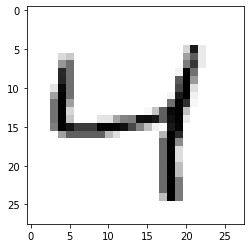

In [16]:
#%%script echo edit here
print(mnist)
print(X_train.shape)
print(y_train.shape)
print(X_train[2,])
print(y_train[:,])
print(max(y_train[:,]))
plt.imshow(X_train[2,:], cmap='Greys')

## Data Normalization

**Alert:** Usually many more steps are involved in preparing data for analysis:
reading, reformating, filtering, shuffeling, transformation, normalization. This can take up a significant amount of time. 

Here we rely on a highly standardize data set and will only use normalization for illustration. It is important to do so consistently for both training and test data.

In [17]:
# Run this code cell only once !!!
run_once=False
if not run_once:
    X_train = X_train / 255.0
    X_test  = X_test  / 255.0
    run_once=True

## Flattening

A common procedure to process images is to first "flatten" them to a vector. This step will ultimately be done inside the neural network.
The line below just illustrates the behaviour for a specific image:

In [18]:
print('original:  ', X_train[42,:].shape)
print('flattened: ', X_train[42,:].flatten().shape)

original:   (28, 28)
flattened:  (784,)


## Dimensional Reduction

**Quiz:** What's the dimensionality of an image? (=How many features does one sample have?)

There are various ways to project high-dimensional data to lower dimensions  - mostly for data exploration and visualization. Below I use PCA.

Scores:  (500, 2)


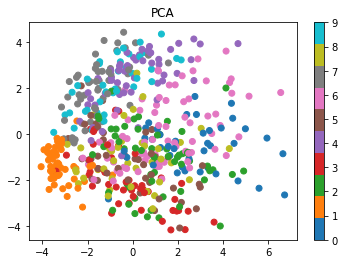

In [19]:
from sklearn.decomposition import PCA

ns = X_train.shape[0] # total number of samples
nr = 500              # random number of subsamples
idx=np.random.choice(ns, nr, replace=False)
X_sub = X_train[idx,:].reshape(nr,-1)  # flatten each of the nr images
X_pca = PCA(n_components = 2).fit_transform(X_sub)
print('Scores: ',X_pca.shape)

cm = plt.get_cmap('tab10')
plt.scatter( X_pca[:,0], X_pca[:,1] , c=y_train[idx], cmap=cm)
plt.title('PCA')
plt.colorbar()
plt.show()

## Define and Compile Neural Network Model

New Elements
- Relu Activation: Rectified Linear Unit (search for simple non-linearity)
- Adam Optimizer: don't get stuck in sharp local minima $\to$ adaptive learning rates (100k citations !)

In [20]:
nc = np.unique(y_train).size  # number of classes / labels in training set
l_name = 'sparse_categorical_crossentropy'
a_name = 'sparse_categorical_accuracy'

input_shape = X_train.shape[1:]

print('X_train.shape:     ', X_train.shape)
print('input_shape:       ', input_shape)
print('number of classes: ', nc)

mod1 = tf.keras.Sequential( name = 'mnist_model_1')
mod1.add( tf.keras.layers.Flatten(input_shape=input_shape) )                # flattens input to vector 
mod1.add( tf.keras.layers.Dense(128, activation='relu',name='1st_layer') )  # add layer with 128 nodes + relu
mod1.add( tf.keras.layers.Dense(nc, activation='softmax', name='softmax_layer') )

mod1.compile(optimizer='sgd', loss=l_name, metrics=a_name)

mod1.summary()

X_train.shape:      (60000, 28, 28)
input_shape:        (28, 28)
number of classes:  10


2022-06-17 11:41:38.464020: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-06-17 11:41:38.465137: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-17 11:41:38.465624: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "mnist_model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
1st_layer (Dense)            (None, 128)               100480    
_________________________________________________________________
softmax_layer (Dense)        (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


# Group Tasks (40 min + 10min):

Now we are ready to go. Repeat the usual steps

- Fitting: start with low number of epochs (~10)
- Tracking of fit performance (Loss, Accuracy)
- Model Evaluation: now you have test data $\ne$ training data
- Predictions: infer labels (np.argmax)
- Iterations and improvements (some ideas)
  - increase the number of epochs
  - increase the number of neurons in dense layer
  - add additional layer
  - introduce a "validation_split" during fitting. Note that this adds additional information to your history that  can be used to control for overfitting.
- Reality check: scan your own handwritten digit and submit it to your learned model. Does it work?

Summary: Report your summary and preferred solution back to the whole class

Tip: If you are on colab.research.google, you might want to activatate the "GPU hardware accelerator" under "Change runtime type"

## Fit Model

In [23]:
fh = mod1.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=10, verbose=0) #, validation_split=0.2)

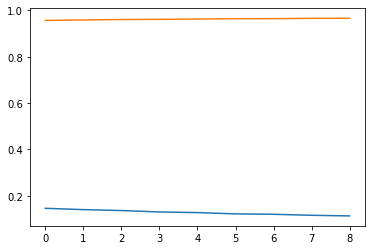

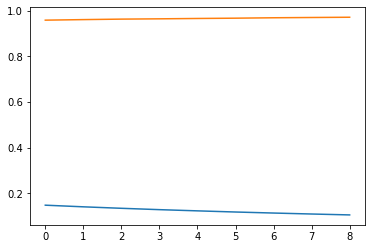

INFO:tensorflow:Assets written to: image_base/assets


In [32]:
plt.plot(fh.history['val_loss'][1:])
plt.plot(fh.history['val_sparse_categorical_accuracy'][1:])

plt.show()

plt.plot(fh.history['loss'][1:])
plt.plot(fh.history['sparse_categorical_accuracy'][1:])

plt.show()


# save: will create a directory of specified name
mod1.save('image_base')

In [26]:
fh_more_epochs = mod1.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=500, verbose=0)

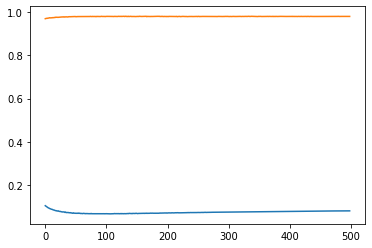

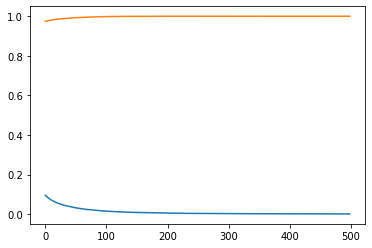

INFO:tensorflow:Assets written to: image_base/assets


In [31]:
plt.plot(fh_more_epochs.history['val_loss'][1:])
plt.plot(fh_more_epochs.history['val_sparse_categorical_accuracy'][1:])

plt.show()

plt.plot(fh_more_epochs.history['loss'][1:])
plt.plot(fh_more_epochs.history['sparse_categorical_accuracy'][1:])

plt.show()


# save: will create a directory of specified name
mod1.save('image_base_more_epochs')

[0.08246175199747086, 0.9793000221252441]


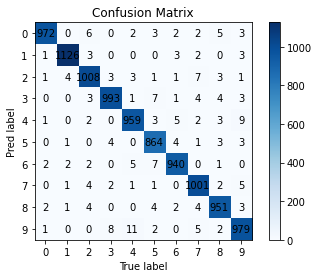

In [36]:
eval = mod1.evaluate(x=X_test, y=y_test, verbose=0)
print(eval)
yp = mod1.predict(X_test)
yp1 = np.argmax(yp, axis=1)
cm = confusion_matrix(yp1, y_test)
plot_cm(cm)

## Evaluation

For exploration and debugging purposes it will be better to decouple
evaluation from the (long) fitting process. But they belong together.

In [ ]:
... plot loss and accuracy ...

... evaluate on _test_data_ ...

... predict on test data ...

... convert prediction to labels ... ---> np.argmax()

... compare predicted labels with known labels y_test ...


## Load own image

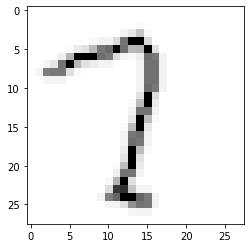

<PIL.Image.Image image mode=RGB size=28x28 at 0x7FCF54793F70>


In [65]:
#%%script echo Make sure to set proper image path and size (to match the model)
from tensorflow.keras.preprocessing import image

img_path= './1_or_2.png'        # set path
input_size=(28, 28)  # chose proper size
img = image.load_img(img_path, target_size=input_size) # load image
plt.imshow(img)
plt.show()

#tf.keras.preprocessing.image.img_to_array(img) # would perhaps also work
# or perhaps even only
# img = image.load_img(fn, target_size=input_size, color_mode="grayscale")
# img = 255-np.array(img)

print(img)

In [66]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread(img_path)

print(img.shape)

#min_col = np.min(img)
#max_col = np.max(img)
#img = (img-min_col)/(max_col-min_col)

img =1- img
#print(img)

mod1.predict(img.reshape(1,28,28))

(28, 28)


array([[3.4124537e-07, 1.0550906e-03, 7.1013016e-01, 2.8466722e-01,
        4.0309814e-07, 2.6790460e-04, 5.1180074e-09, 1.4615131e-03,
        2.4172782e-03, 4.3330317e-08]], dtype=float32)

pass your image to the neural network and predict the label!